# Machine Learning  - PUC-RIO
### Aluno: Andrieles de Souza Rodrigues


# Definição do Problema

## MVP: Classificação

Problema: Classificar a qualidade de maçãs como boas ou ruins com base em sete  caracteristicas: tamanho,  peso,  doçura,  crocância,  suculência,  maturação e acidez.

Dataset: apple_quality.csv

Fonte do dataset: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para testar os hiperparâmetros
from sklearn.feature_selection import SelectKBest, chi2 # para feature selection
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.ensemble import RandomForestClassifier # algoritmo RF (ensemble)
from sklearn.ensemble import AdaBoostClassifier # algoritmo adaboost(ensemble)

# Preparação do Dados

In [ ]:
# Carga do dataset para um Dataframe

url_dataset = 'https://raw.githubusercontent.com/Andrieles/datascience/main/datasets/apple_quality.csv'

dataset = pd.read_csv(url_dataset,sep=',')

dataset = dataset.drop(dataset.index[-1]) # Remove última linha do dataset correspondente aos créditos do autor do dataset

dataset.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [ ]:
# Verificação dos tipos de dados das colunas.

# No caso, a coluna "Acidity" está com um tipo indesejado. Isso ocorreu devido a última linha do dataset ter justamante na coluna 7 os creditos do autor.

dataset.dtypes

A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality         object
dtype: object

In [ ]:
# Convertendo a coluna "Acidity" para o tipo de dado correto, no caso ponto flutuante.

dataset['Acidity'] = dataset['Acidity'].astype(float)

In [ ]:
# Normalização

colunas = ['Size','Weight','Sweetness','Crunchiness','Juiciness','Ripeness','Acidity'] # Definindo quais serão os atributos a serem normalizados

dataset_norm = (dataset[colunas] - dataset[colunas].min()) / (dataset[colunas].max() - dataset[colunas].min()) # Fazendo a normalização

for i in colunas:
    dataset.insert(len(dataset.columns) - 1, str(i) + '_norm', dataset_norm[i]) # Inserindo os colunas com os dados normalizados no Dataframe

In [ ]:
# Verificando os valores máximo, mínimo, mediana e tipo dos dado de cada coluna de atributos (incluindo normalizados).

dataset_subset = dataset.iloc[:,1:15] # Separando as colunas de atributo e atrinutos normalizados

min_values = dataset_subset.min() # Valores mínimos
max_values = dataset_subset.max() # Valores máximos
median_values = dataset_subset.median() # Mediana
type_values = dataset_subset.dtypes # Tipo de dados

result_df = pd.DataFrame({  # Montando o Dataframe para exibição
    'Mínimo': min_values,
    'Máximo': max_values,
    'Mediana': median_values,
    'Tipo:': type_values
})

result_df.transpose() # Invertendo as linhas e colunas para melhorar a visualização

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Size_norm,Weight_norm,Sweetness_norm,Crunchiness_norm,Juiciness_norm,Ripeness_norm,Acidity_norm
Mínimo,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Máximo,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Mediana,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,0.489598,0.476418,0.481538,0.515785,0.487466,0.48602,0.487895
Tipo:,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


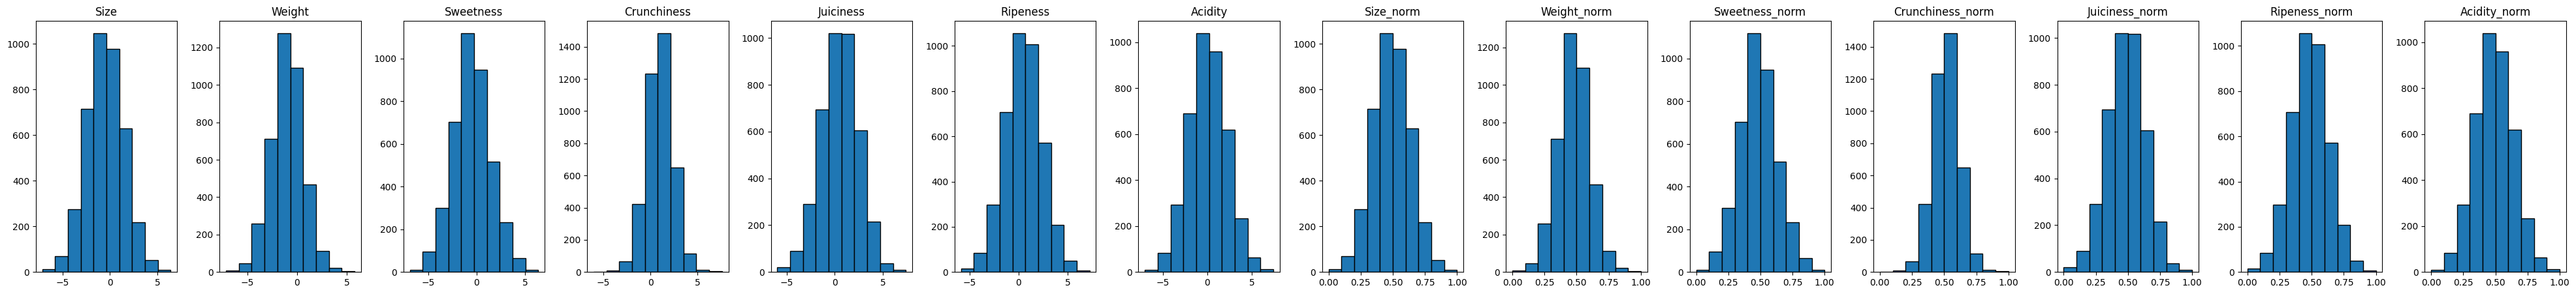

In [ ]:
# Histograma

dataset_hist = dataset.copy() # Cria copia do Dataframe

dataset_hist.drop(['A_id','Quality'], axis=1, inplace=True) #Remove as colunas que não interessam para a confecção do histograma.

# Defina o formato para subplots (1 linha e 3 colunas)
fig, axis = plt.subplots(1, 14, figsize=(50, 5))

# Crie um histograma para cada coluna
dataset_hist.hist(ax=axis, edgecolor='black', grid=False)

# Exibe os histogramas
plt.show()

In [ ]:
# Feature Selection

# Definindo uma seed global para esta célula de código
np.random.seed(42)

array = dataset.values #Cria array com valores

X = array[:,8:15] # atributos normalizados
y = array[:,15] # classe (target)


# Criando um DataFrame com as características
df_feature_selection = pd.DataFrame(X, columns= list(dataset.columns[8:15]))

# Selecionando as K melhores características usando o teste qui-quadrado
k_best = SelectKBest(score_func=chi2, k=6) # Selecionando os 6 melhores atributos
X_new = k_best.fit_transform(X, y)

# Obtendo os índices das características selecionadas
selected_indices = k_best.get_support(indices=True)

# Exibindo as características selecionadas
selected_features = df_feature_selection.columns[selected_indices]
print(f"Características selecionadas: {', '.join(selected_features)}")

Características selecionadas: Size_norm, Sweetness_norm, Crunchiness_norm, Juiciness_norm, Ripeness_norm, Acidity_norm


# Conclusões da analise exploratória:

O dataset escolhido é comporto de uma coluna de indice(não necessária para o problema), sete colunas de caracteristicas de uma maçã (nossos atributos) e uma coluna com a classificação da fruta como boa ou ruim(nossa classe).

É possivel observar que os sete atributos possuem valores que estão variando entre -7~ e +7\~, e com uma mediana em 0\~. Verificando os valores com um histograma podemos observar que os valores medianos são bem mais numerósos que os valores periféricos. Ao normalizar os dados não observo uma mudança na forma dos histograma. Presumo, então, que não há muito ganho com relação a normalização dos dados.

Aproveitando os dados já normalizados para fazer uma tentativa de "Feature Selection" usando *SelectKBest* com *chi2*. Porém, o treito nos modelos com base em menos parametros resultou em uma queda drastica da acurácia.

Portanto, estou optanto por manter os sete atributos e fazer uso dos dados não normalizados. Mas, estou mantenho na célula abaixo, comentádos, a atribuição de X para valores normalizados e selecionados.


### Preparando dados para o treinamanto

In [ ]:
# Separação em bases de treino e teste (holdout)
array = dataset.values

# Separando os atributos da classe

X = array[:,1:8] # atributos
# X = array[:,8:15] # atributos normalizados
# X = array[:,[8,10,11,12,13,14]] # 6 atributos normalizados (feature selection)
y = array[:,15] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1979) # faz a divisão entre treino e teste

# Criando os folds para a validação cruzada
num_particoes = 5 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42) # faz o particionamento em 10 folds

# Modelagem e treinamento:

KNN: 0.892500 (0.005358)
CART: 0.804688 (0.009682)
NB: 0.753750 (0.005728)
SVM: 0.881563 (0.013310)
RandomForest: 0.879375 (0.008970)
AdaBoost: 0.770312 (0.007718)


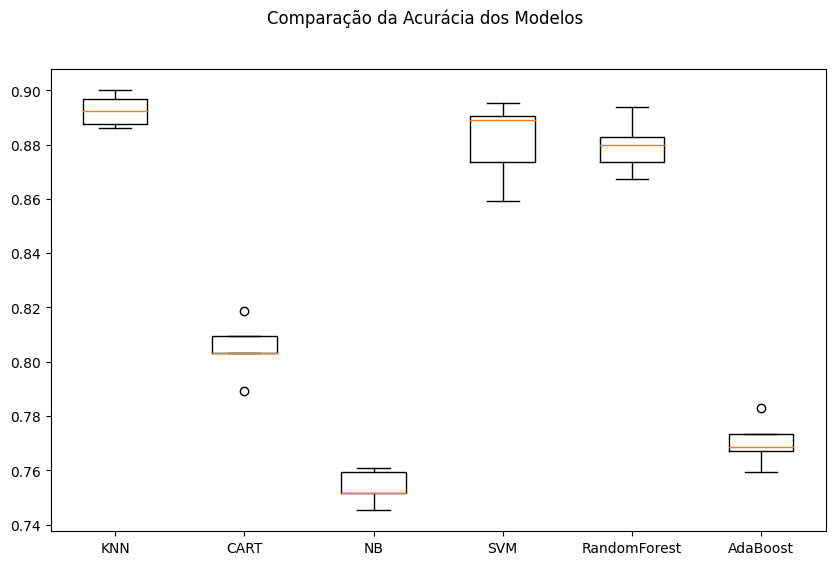

In [ ]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(42)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42))) # ensemble
models.append(('AdaBoost', AdaBoostClassifier(n_estimators=50, random_state=42))) # ensemble


# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Acima fiz uso dos quatro algoritmos propostos na aula de sobre classificadores e mais dois algoritmos de ensemble.

Os modelos KNN, CART, NB, SVM foram treinados sem ajustes de hiperparâmetros. Já nos ensembles RandomForest e AdaBoost inclui uma quantidade de estimadores arbitrária e uma seed para garantir resultados replicáveis.

Fiz uso da validação crusada com K-Folds para tentar mistigar qualquer viés ou variância.

Não observei underfitting.

Escolhi os três algoritmos com a melhor acuráricia e menor desvio padrão. São eles KNN, o SVN e o RandomForest para a próxima célula que tratará do refinamento de hiperparâmetros e teste.

### Avaliando hiperparâmetros e testando

In [ ]:
# Teste

# Definindo uma seed global para esta célula de código
np.random.seed(42)

# Listas para armazenar os modelos e os resultados dos testes
models = []
results = []

svc_params = {'C': [0.1, 1, 11, 31, 45], 'kernel': ['linear', 'rbf']} # hiperparâmetros para SVC
knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']} # hiperparâmetros para KNeighborsClassifier
rf_params = {'n_estimators': [1, 25, 50, 100, 1000], 'random_state': [42]} # hiperparâmetros RandomForestClassifier

models.append(('KNN', KNeighborsClassifier(), knn_params))
models.append(('SVM', SVC(), svc_params))
models.append(('RandomForest', RandomForestClassifier(), rf_params))

# Avaliando um hiperparâmetro por vez, escolhendo o melhor e fazendo o teste
for name, model, h_param in models:
    grid = GridSearchCV(model,h_param, cv=kfold)
    grid.fit(X_train, y_train)
    acc = accuracy_score(y_test, grid.predict(X_test))
    results.append((name, acc, grid.best_params_))


Na célula acima, após selecionar os três modelos que melhor performaram, faço uso do GridSearchCV para treina-los com alguns conjuntos de hiperparâmetros.

Após o treino utilizando validação cruzada com kfold para cada conjunto de  hiperparâmetros, utilizo a configuração com melhor score para fazer a previsão com base nos dados de teste.

Na próxima célula apresento os resultados dos testes para os três modelos seguido do conjusnto de hiperparâmetros usados para alcançar o resultado.

# Avaliação de Resultados:

In [ ]:
# Exibe os resultados
df_result_grid = pd.DataFrame(results, columns=["Modelo","Acurácia do teste","Hiperparâmetros"])
df_result_grid = df_result_grid.sort_values(by= "Acurácia do teste", ascending= False)
df_result_grid = df_result_grid.reset_index(drop=True)

df_result_grid

,Modelo,Acurácia do teste,Hiperparâmetros
0,SVM,0.92750,"{'C': 45, 'kernel': 'rbf'}"
1,KNN,0.89875,"{'n_neighbors': 7, 'weights': 'distance'}"
2,RandomForest,0.87125,"{'n_estimators': 1000, 'random_state': 42}"


# Conclusões:


